# Player Segmentation Node

For clustering players based on their attributes, we can use *unsupervised machine
learning* algorithms such as K-Means or Hierarchical clustering.

**K-Means** is a popular algorithm for clustering data points into a specified number
 of clusters based on similarity in their attributes. **Hierarchical clustering**, on
  the other hand, creates a hierarchy of clusters and sub-clusters based on the
  similarity of their attributes.

## Which one to use?

To decide which algorithm to use, I considered the size of the dataset
and the desired number of clusters. **K-Means** is computationally faster and efficient
for larger datasets, while **Hierarchical clustering** is suitable for smaller datasets.

The main difference between the two algorithms lies in their approach to form
clusters:

> `K-Means` is a **partition-based** clustering algorithm that groups data points into a
pre-defined number of clusters. It starts by selecting **random centroids** (cluster
 centers) and then iteratively assigns each data point to the nearest centroid based
 on the distance metric. After all the points are assigned, the centroids are
 updated by taking the mean of all the points in the cluster. The algorithm repeats
 the process until the centroids no longer change, and the clusters become stable.

> `Hierarchical clustering` is a **connectivity-based** clustering algorithm that does
 not require a pre-defined number of clusters. It creates a hierarchy of clusters by
 iteratively merging or splitting clusters based on the similarity of their
 attributes. Hierarchical clustering can be performed in **two ways**: `agglomerative`
 and `divisive`. In `agglomerative` clustering, each data point starts in its own
 cluster, and clusters are successively merged until only one cluster remains. In
 `divisive` clustering, all data points start in one cluster, and clusters are
 successively split until each data point is in its own cluster.

To summarize, **K-Means** algorithm partitions the data into a fixed number of clusters
and iteratively optimizes the centroid positions to minimize the distance between
data points and their assigned cluster. **Hierarchical clustering**, on the other hand,
creates a hierarchy of clusters based on the similarity between the data points and
iteratively merges or splits clusters to form the final clusters.

## What can I analyze with the player metadata?

Based on the player metadata, we can use the following criteria to cluster the players:

- `Trophies`: The number of trophies a player has earned in the game is a significant
 indicator of their performance level and skill.
- `3v3 Victories`: This attribute shows how many 3v3 matches the player has won,
which could be an indication of their teamwork ability.
- `Solo Victories and Duo Victories`: These attributes represent how many Solo or Duo
matches the player has won, indicating their ability to play effectively without the
support of teammates.
- `Best RoboRumbleTime`: This attribute represents the player's best time in defeating
the robots in the Robo Rumble event, which indicates their skill in handling PvE
(player versus environment) situations.

In [74]:
import warnings
warnings.filterwarnings('ignore')

# Set up notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

home_directory = "C:/Users/rober/PycharmProjects/Brawlstars-retention-pipeline"

metadata_prepared = pd.read_csv(
    filepath_or_buffer=home_directory +
                       "/data/03_raw_metadata/metadata_prepared_original.csv"
)

Said this the classification will be performed using a **K-Means** algorithm.

## Data Preparation

Let's start by checking the NaN values

In [75]:
clustered_data = metadata_prepared; clustered_data.head()

,player_id,trophies,highestTrophies,highestPowerPlayPoints,expLevel,expPoints,3vs3Victories,soloVictories,duoVictories,bestRoboRumbleTime
0,#8Y9QGR0U,41103,42113,544.0,247,313184,18746,1332,663,1
1,#99QU9PU2,51754,55004,1204.0,411,858011,64497,900,1132,9
2,#GG9YJJY,21897,35635,1013.0,310,491272,37032,1217,600,0
3,#VJUQ0Y,57372,61076,1380.0,412,862979,63416,1348,780,5
4,#PJGGV2Q80,59129,61757,1362.0,359,654132,48834,558,2838,13


In [76]:
nan_per_col = clustered_data.isna().sum()
print('NAN values per column: ', nan_per_col[nan_per_col > 0])

NAN values per column:  highestPowerPlayPoints    322
dtype: int64


Since `highestPowerPlayPoints` refers to the highest score in a competitive mode
that is no longer active, we will remove it. After all, according to [Brawlstars
Wiki](https://brawlstars.fandom.com/wiki/Power_Play#:~:text=Power%20Play%20Points&text=The%20total%20number%20of%20Power,could%20be%20earned%20is%201386) this competitive mode could be unlocked after earning a Star Power for any Brawler,
meaning that won't be a descriptive attribute for every player.

In [77]:
clustered_data = clustered_data.drop('highestPowerPlayPoints', axis=1)
clustered_data.head()

,player_id,trophies,highestTrophies,expLevel,expPoints,3vs3Victories,soloVictories,duoVictories,bestRoboRumbleTime
0,#8Y9QGR0U,41103,42113,247,313184,18746,1332,663,1
1,#99QU9PU2,51754,55004,411,858011,64497,900,1132,9
2,#GG9YJJY,21897,35635,310,491272,37032,1217,600,0
3,#VJUQ0Y,57372,61076,412,862979,63416,1348,780,5
4,#PJGGV2Q80,59129,61757,359,654132,48834,558,2838,13


Before training a `KMeans` model, it's necessary to prepare the data by scaling it and
selecting the appropriate features. As I mentioned in one on my [experiments](https://github.com/robguilarr/Machine-Learning-Sandbox/blob/master/source/experiments/unsupervised_machine_learning/KMeans.ipynb), in cases when we have
sparse data or features with very different scales, and we want to preserve the sparsity and relative magnitudes of the data we should use `MaxAbsScaler`.

In [78]:
from sklearn.preprocessing import MaxAbsScaler

X = clustered_data.drop('player_id', axis=1).values
player_id = clustered_data[['player_id']].values

maxAbsScaler = MaxAbsScaler()
X_scaled = maxAbsScaler.fit_transform(X)

In [79]:
print(X)
print(player_id)
print(X_scaled)

[[41103 42113   247 ...  1332   663     1]
 [51754 55004   411 ...   900  1132     9]
 [21897 35635   310 ...  1217   600     0]
 ...
 [27912 37568   307 ...   616  1737     5]
 [38360 52570   295 ...   927  4255     8]
 [53405 55555   325 ...   581  3945     8]]
[['#8Y9QGR0U']
 ['#99QU9PU2']
 ['#GG9YJJY']
 ...
 ['#8L89CJL']
 ['#2JGUC2C0']
 ['#LGC0PQ98']]
[[0.56835686 0.50846373 0.494      ... 0.06924157 0.01933001 0.05      ]
 [0.7156349  0.66410702 0.822      ... 0.04678484 0.03300388 0.45      ]
 [0.3027835  0.43024969 0.62       ... 0.0632635  0.01749322 0.        ]
 ...
 [0.38595666 0.45358833 0.614      ... 0.03202162 0.05064288 0.25      ]
 [0.53042769 0.63471941 0.59       ... 0.04818839 0.12405609 0.4       ]
 [0.7384643  0.67075968 0.65       ... 0.03020221 0.11501793 0.4       ]]


Now let's train the model, we first need to instantiate the KMeans class from
scikit-learn, and specify the number of clusters `(n_clusters)` and other
hyperparameters. In this example, we'll use `n_clusters=3` since we know that there are
 3 clusters in the dataset. We'll also set `random_state=42` to ensure reproducibility
 of results. Then, we fit the model to the scaled data using the fit method.

In [81]:
# Train KMeans model
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

labels = kmeans.predict(X_scaled)
print(labels)

[0 1 0 ... 0 1 1]


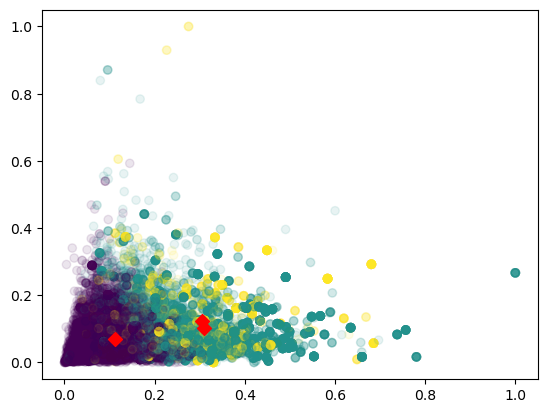

In [87]:
import matplotlib.pyplot as plt

centroids = kmeans.cluster_centers_
centroids_x = centroids[:,4]
centroids_y = centroids[:,5]

ys = maxAbsScaler.fit_transform(clustered_data["soloVictories"].values.reshape(-1,1))
xs = maxAbsScaler.fit_transform(clustered_data["3vs3Victories"].values.reshape(-1,1))
plt.scatter(xs, ys, c=labels, alpha=0.1)

plt.scatter(centroids_x, centroids_y, marker='D', s=50, c= 'red')
plt.show()

In [85]:
centroids


array([[0.39460969, 0.41535272, 0.47132827, 0.23043598, 0.11129504,
        0.07027864, 0.0604129 , 0.31422045],
       [0.6409163 , 0.61477986, 0.69261807, 0.47604604, 0.30984141,
        0.10204907, 0.09165207, 0.33366954],
       [0.63463576, 0.62240317, 0.69378194, 0.48154197, 0.30538442,
        0.12225858, 0.1056753 , 0.9339207 ]])

## Conclussions

After clustering the players, we can draw conclusions about their performance, skill
level, and the game mode in which they excel.

For example, if a particular cluster has players with high trophies, 3vs3 victories,
and best RoboRumbleTime, they could be classified as highly skilled players with good
 teamwork and PvE abilities. Similarly, a cluster with players having high solo and
 duo victories could be classified as excellent solo and duo players.

Overall, clustering can help you understand player behavior and preferences, and we
can use these insights to improve the game experience for the players.